# Report Title

---

_**Brief Report Objective**_

---


## Table of Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Validation and Cleaning](#Data-Validation-and-Cleaning)
1. [Train Test Split](#Train-Test-Split)
1. [Numerical EDA](#Numerical-EDA)
1. [Graphical EDA](#Graphical-EDA)
1. [Feature Engineering](#Feature-Engineering)
1. [Data Preprocessing](#Data-Preprocessing)
1. [Baseline Model](#Baseline-Model)
1. [Model Building, Selection, and Evaluation](#Model-Building-Selection-and-Evaluation)
1. [Baseline Model Comparison](#Baseline-Model-Comparison)
1. [Final Model Evaluation](#Final-Model-Evaluation)
1. [Conclusion](#Conclusion)
1. [Appendix](#Appendix)

---


### Introduction

**Objective**: Extended Report Objective (What type of Machine Learning task is this ? What are you looking to find out ?)

Our dataset we are analyzing contains information about **{{ data_description }}**. It has **{{ data_columns }}** columns and **{{ data_rows }}** rows.

The columns of the dataset are:
1. `predictor_column_1` - *description*
1. `predictor_column_2` - *description*
1. `predictor_column_3` - *description*
1. `predictor_column_4` - *description*
1. `target_column` **(target)** - *description*

We are trying to predict `target_column` using the other variables as our predictors. 

First, we will perform *exploratory data analysis* (EDA) to better understand the relationships of our predictors to `target_column`. Next, we will *create new features from our existing data* (feature engineering) to explore new relationships with `target_column` with the hope of increase our model's predcitive power. We will then transform our data into a format our models understand and evaluate their performance using *cross validation*, and choose a few candidate models to fine tune. Once we have fine tuned the hyperparameters of our candidate models, we can evaluate their performance using *cross validation*, and select the model which performed the best. This allows us to estimate our model will do in *production* (ie, how well it will predict future observations). Finally, we will tie together all of the steps from into a *pipeline* so that our code is as compact and understandable as possible and perform one final evaluation on our test set.

---

### Setup

Import all the Python libraries we will need

---

In [87]:
# Add imports here
from itertools import combinations
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats
import phik

In [88]:
# Read in Data from Database
# conn = os.environ["DB_URL"]
# query = ""
# data = pd.read_sql(query, con=conn)
# Read in Data from CSV
data = pd.read_csv("../data/toyota.csv")
# Preview Dataframe
data.head()

# If problems are identified in preview fix them here (wrong column headers, wrong delimiter, etc.)

model  year  price transmission  mileage fuelType  tax   mpg  engineSize
0   GT86  2016  16000       Manual    24089   Petrol  265  36.2         2.0
1   GT86  2017  15995       Manual    18615   Petrol  145  36.2         2.0
2   GT86  2015  13998       Manual    27469   Petrol  265  36.2         2.0
3   GT86  2017  18998       Manual    14736   Petrol  150  36.2         2.0
4   GT86  2017  17498       Manual    36284   Petrol  145  36.2         2.0

### Data Validation and Cleaning

---

In [89]:
# Drop duplicates
duplicate_count = len(data) - len(data.drop_duplicates())
if duplicate_count > 0:
    print(f"{duplicate_count} duplicate rows found\nTo examine them run: data[data.duplicated(keep=False)]\nTo drop them run: data.drop_duplicates(inplace=True)")
    data.drop_duplicates(inplace=True)
    print(f"Dropped {duplicate_count} duplicate rows")

39 duplicate rows found
To examine them run: data[data.duplicated(keep=False)]
To drop them run: data.drop_duplicates(inplace=True)
Dropped 39 duplicate rows


In [90]:
# Shape of data, dtypes, NULL Counts, duplicate rows, dtype counts, distributions of numeric columns, # of unqiue values for string / categorical types

# Shape of data
print(f"Dataframe has {data.shape[0]} rows and {data.shape[1]} columns")
print("\n")

# Data Types and Missing Values
print(f"Data Types, Missing Values Per Column, and Unique Values Per Column:\n")
df_overview = pd.DataFrame({
    "Column Name": data.columns,
    "Data Type": data.dtypes,
    "# Missing Values": data.isnull().sum(),
    "% Missing Values": data.isnull().mean() * 100,
    "Unique Values": data.nunique()
}).sort_values(by=["Data Type", "% Missing Values"]).reset_index(drop=True)
display(df_overview)
print("\n")

# Data Types Counts
print(f"Data Types Counts:\n")
display(data.dtypes.value_counts())

Dataframe has 6699 rows and 9 columns


Data Types, Missing Values Per Column, and Unique Values Per Column:



Column Name Data Type  # Missing Values  % Missing Values  Unique Values
0          year     int64                 0               0.0             23
1         price     int64                 0               0.0           2114
2       mileage     int64                 0               0.0           5699
3           tax     int64                 0               0.0             29
4           mpg   float64                 0               0.0             81
5    engineSize   float64                 0               0.0             16
6         model    object                 0               0.0             18
7  transmission    object                 0               0.0              4
8      fuelType    object                 0               0.0              4



Data Types Counts:



int64      4
object     3
float64    2
dtype: int64

Numeric Variables Summary Statistics



year         price        mileage          tax          mpg  \
count  6699.000000   6699.000000    6699.000000  6699.000000  6699.000000   
mean   2016.742797  12529.799074   22889.588745    94.549933    63.078728   
std       2.205271   6358.562625   19109.288501    73.942649    15.861037   
min    1998.000000    850.000000       2.000000     0.000000     2.800000   
25%    2016.000000   8266.500000    9488.500000     0.000000    55.400000   
50%    2017.000000  10798.000000   18571.000000   135.000000    62.800000   
75%    2018.000000  14995.000000   31059.500000   145.000000    70.600000   
max    2020.000000  59995.000000  174419.000000   565.000000   235.000000   

        engineSize  
count  6699.000000  
mean      1.471996  
std       0.435624  
min       0.000000  
25%       1.000000  
50%       1.500000  
75%       1.800000  
max       4.500000

Distributions of Numeric Columns:



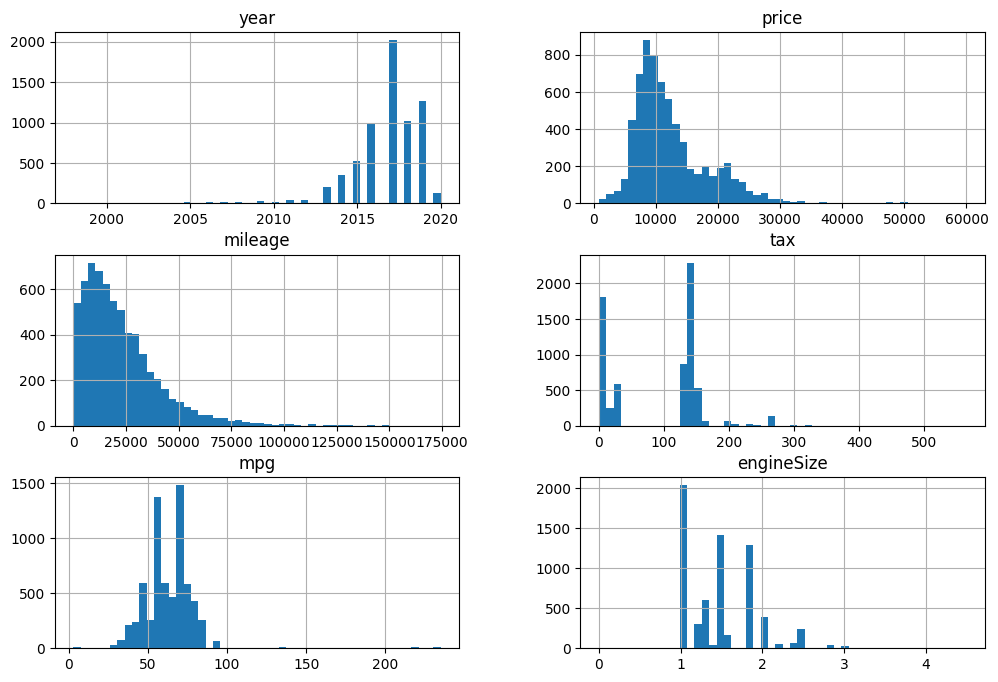

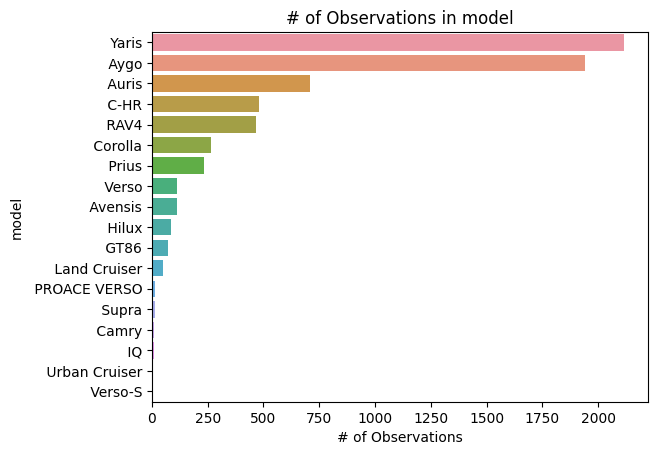

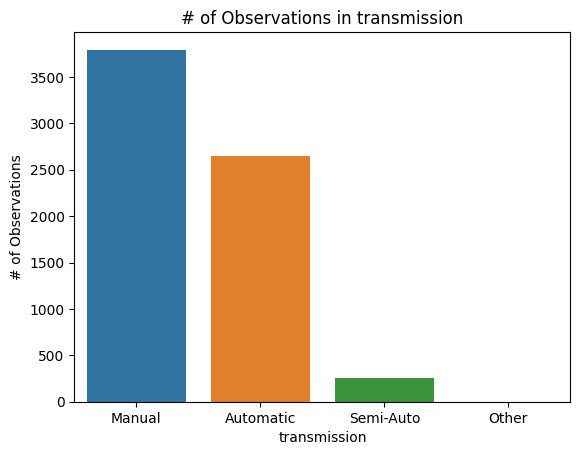

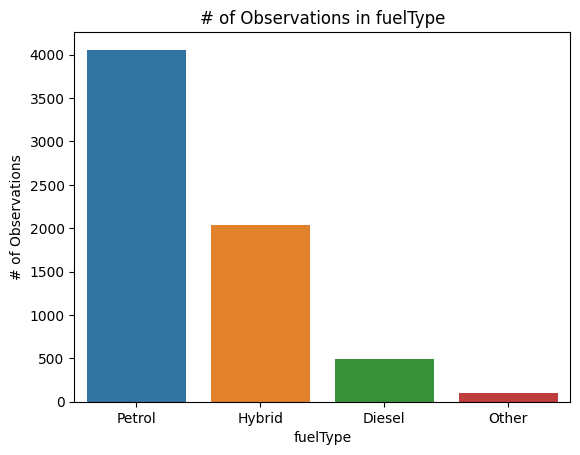

In [91]:
# Summary Statistics
print(f"Numeric Variables Summary Statistics\n")
display(data.describe())

# Distributions of Numeric Columns
print(f"Distributions of Numeric Columns:\n")
data.hist(figsize=(12, 8), bins=50)
plt.show()

# Count plots of categorical columns
for col_name in data.select_dtypes(exclude="number").columns:
    nunique = data[col_name].nunique()
    desc_order = data[col_name].value_counts().index
    if nunique > 5 and nunique < 20:
        sns.countplot(data=data, y=col_name, order=desc_order)
        plt.title(f"# of Observations in {col_name}")
        plt.xlabel("# of Observations")
        plt.ylabel(col_name)
        plt.show()
    elif nunique <= 5:
        sns.countplot(data=data, x=col_name, order=desc_order)
        plt.title(f"# of Observations in {col_name}")
        plt.ylabel("# of Observations")
        plt.xlabel(col_name)
        plt.show()
    else:
        print(f"🚨 {col_name} column had 20 or more unique values, so distribution skipped. Consider binning this variable 🚨")
        print(f"Here are the 5 most common values:\n{data[col_name].value_counts().head(5)}")

**{{ make observation on what needs to be cleaned up or addressed now vs later }}**

**Changing of dtypes, handling of nulls, high cardinality categorical variables, etc.**

* Are some columns the wrong datatype ?
* Are there columns with a lot of NULL values ?
* Are there categorical columns with > 4 categories ?
* Could some columns be better represented via binning ? (Converting a `numeric` variable into `catgeorical`)

**Distribution Types, Outliers, General Aknowledgements**

* Are any distributions skewed? Consider applying some common transformations (square root, log, etc.) in the preprocessing step of your pipeline.
  * Features that are strictly positive and have a heavy right tail generally benefit from square root or raising to a power between 0 and 1. Features with a very long and heavy tail (such as a power law distribution) generally benefit from replacing the feature with its logarithm.
  * In simpler words, if the feature's values spread out to the right, but not too rapidly, use the square root transformation. If the values spread out significantly and decrease very quickly as they get larger, then the log transformation can be more appropriate.

* Do you notice any common distributions (Normal, Bimodal, Exponential, etc.) ?
  * What does impact does this have on Data Preprocessing (Scaling, Centering, etc.) ?
  * What techniques can be used for 

* Are there a lot of outliers for any of the columns ?

* Do any variables lend themselves to binning / are there "numeric" variables that actually represent discrete categories ?
  * Be aware of impacts on model. If you use a linear model and predictor has a linear relationship with target, then binning isn't recommended.

* Did some of the distributions lead you to a follow up question (check outliers, etc.) ? If so explore them here

* Are there very few observations for any of the classes of a variable ?
  * Should you use stratified sampling?
  * What does impact does this have on Data Preprocessing (Train Test Split / classes in Train but not Test) ?

In [92]:
# Clean data / address issue to fix now

# 🚨 Before you do any more EDA, you need to split your data into training and test sets and never look at the test set 🚨

In [93]:
from sklearn.model_selection import train_test_split

# 🚨 Replace with target column name 🚨
target = "price"

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

### Numerical EDA

---

In [94]:
# Shape of train_data, dtypes, NULL Counts, dtype counts, distributions of numeric columns, # of unqiue values for string / categorical types, possible outliers etc.
## You can get a very good and quick EDA using pandas-profiling

# Create pandas_profiling EDA Report
profile = ProfileReport(train_data, title="Pandas Profiling Report")
# Display pandas_profiling EDA Report
profile.to_notebook_iframe()

# Identify Potential Outliers using the IQR Method
quant1 = []
quant3 = []
int_quartile_range = []
outlier_counts = []
for col_name in train_data.select_dtypes("number").columns:
    q1 = train_data[col_name].quantile(0.25)
    q3 = train_data[col_name].quantile(0.75)
    iqr = q3 - q1
    outlier_count = len(train_data[col_name][(train_data[col_name] < (q1 - 1.5 * iqr)) | (train_data[col_name] > (q3 + 1.5 * iqr))])
    outlier_counts.append(outlier_count)
    quant1.append(q1)
    quant3.append(q3)
    int_quartile_range.append(iqr)
outlier_df = pd.DataFrame({
    "column": train_data.select_dtypes("number").columns,
    "q1": quant1,
    "q3": quant3,
    "iqr": int_quartile_range,
    "outlier_count": outlier_counts
}).sort_values(by="outlier_count", ascending=False).reset_index(drop=True)
print(f"\nNumber of potential outliers per column (IQR method)\n")
print(f"To examine outliers run: train_data[((train_data[col_name] < (q1 - 1.5 * iqr)) | (train_data[col_name] > (q3 + 1.5 * iqr)))]")
display(outlier_df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]



Number of potential outliers per column (IQR method)

To examine outliers run: train_data[((train_data[col_name] < (q1 - 1.5 * iqr)) | (train_data[col_name] > (q3 + 1.5 * iqr)))]


column      q1       q3      iqr  outlier_count
0     mileage  9606.5  31267.5  21661.0            223
1       price  8250.0  14995.0   6745.0            198
2        year  2016.0   2018.0      2.0            171
3         mpg    55.4     70.6     15.2            116
4         tax     0.0    145.0    145.0              3
5  engineSize     1.0      1.8      0.8              2

**{{ make_observations_here }}**

**Potential outliers, handling of nulls, high cardinality categorical variables, etc.**

* Did you forget to change some columns to the correct types ?
* Are there a lot of outliers for any of the columns ?
* Do any of the quantiles stick out right away ? Be sure to analyze these when doing Graphical EDA
* Check out some of the outliers and see if they could be legit outliers or not. Graphical EDA can help visualize this

### Graphical EDA

---

/var/folders/7r/kt5n63tx35qgs41q12b8z_3w0000gn/T/ipykernel_40855/2950708462.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = sns.heatmap(train_data.corr(method="pearson"),


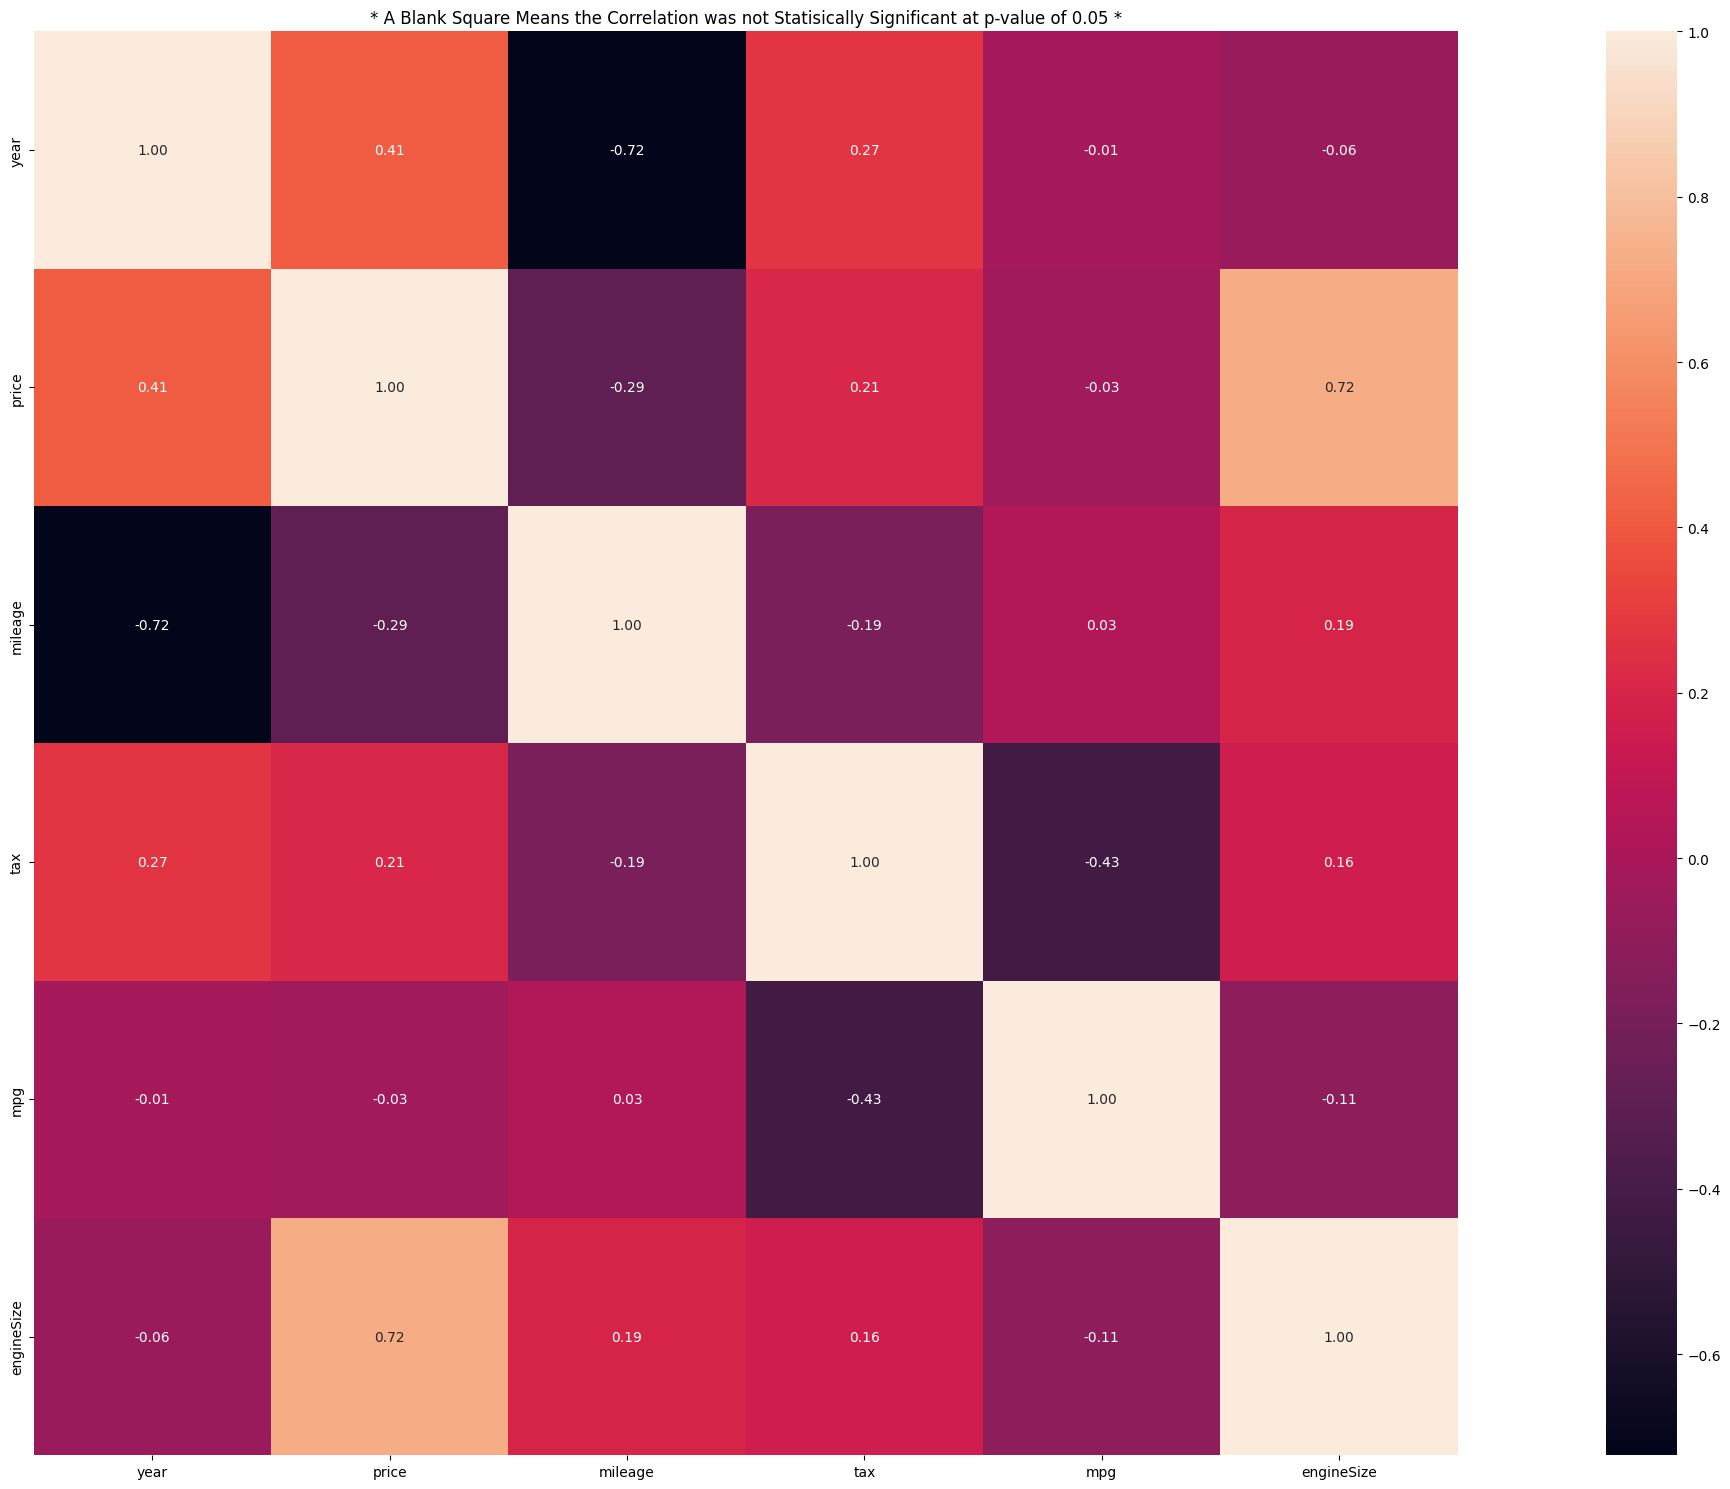

In [95]:
# Pearson's r Correlation Heatmap
# Correlation Matrix

# Code to "mask" correlations that are not statistically significant from heatmap
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = scipy.stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# p_values = corr_sig(train_data.select_dtypes('number'))
# mask = np.invert(np.tril(p_values<0.05))

# Set up the matplotlib figure
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(30, 15))

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(train_data.corr(method="pearson"),
                    #    mask=mask,
                       annot=True,
                       fmt='.2f',
                       square=True)
g.set(title="* A Blank Square Means the Correlation was not Statisically Significant at p-value of 0.05 *")
f.set_tight_layout(True)

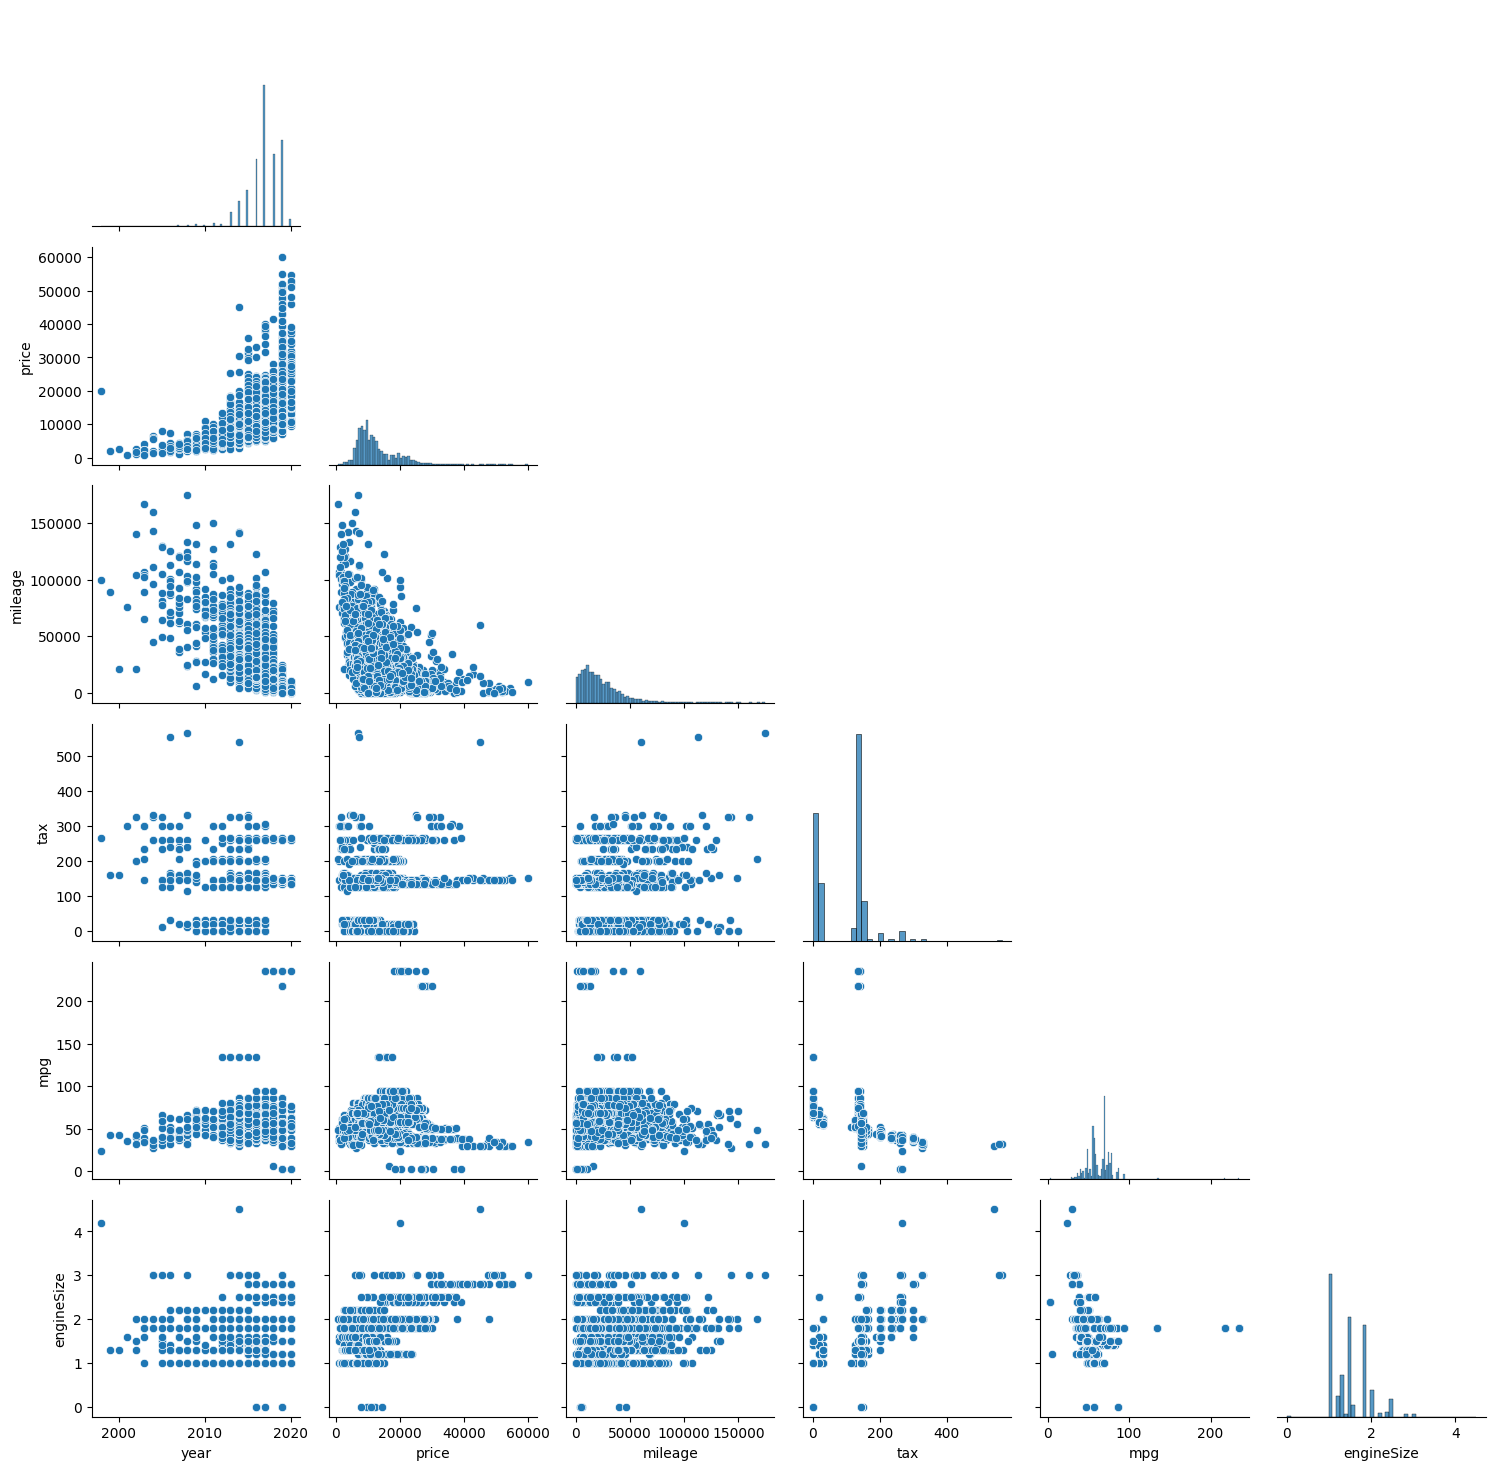

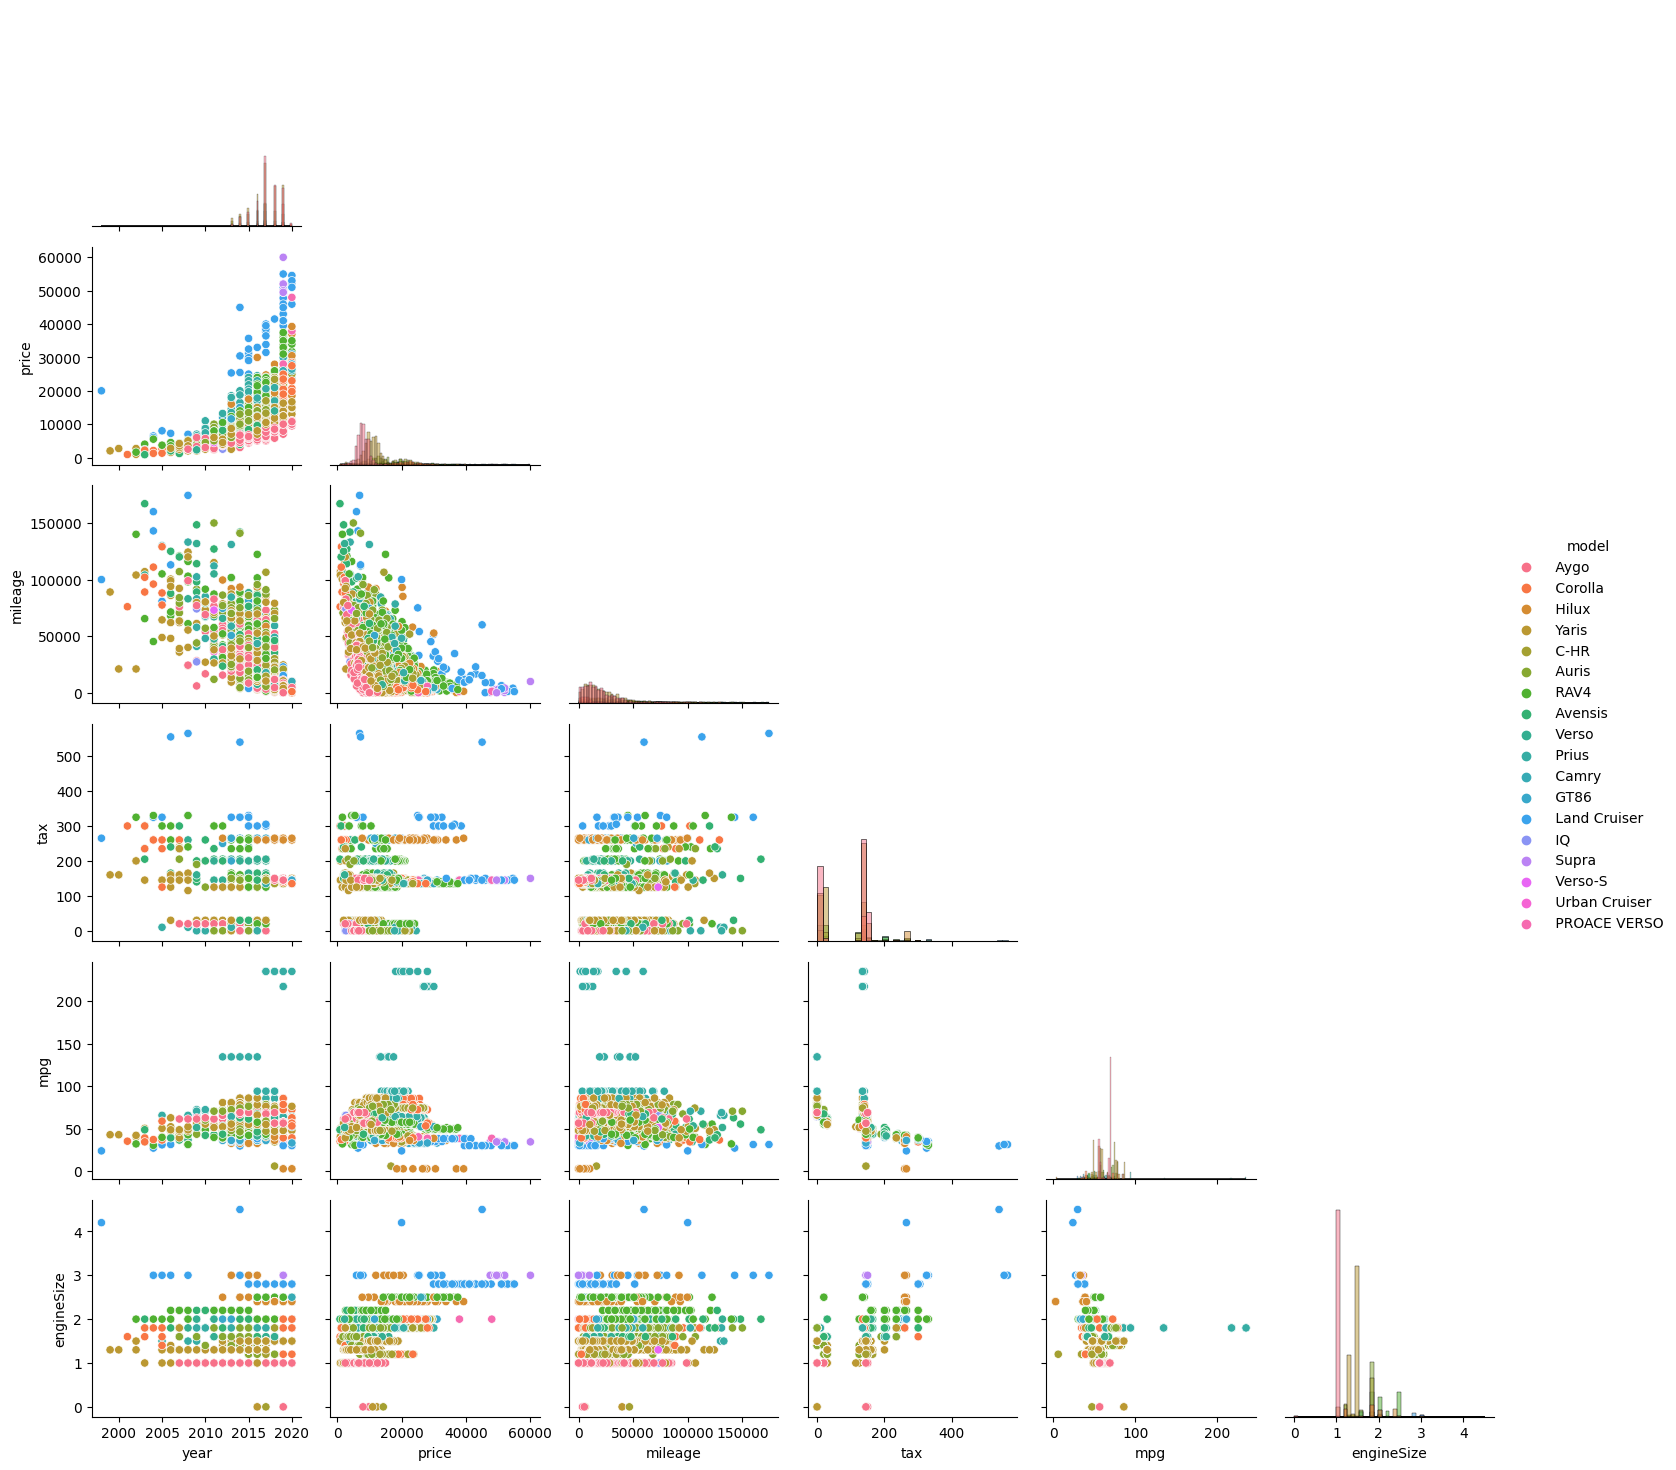

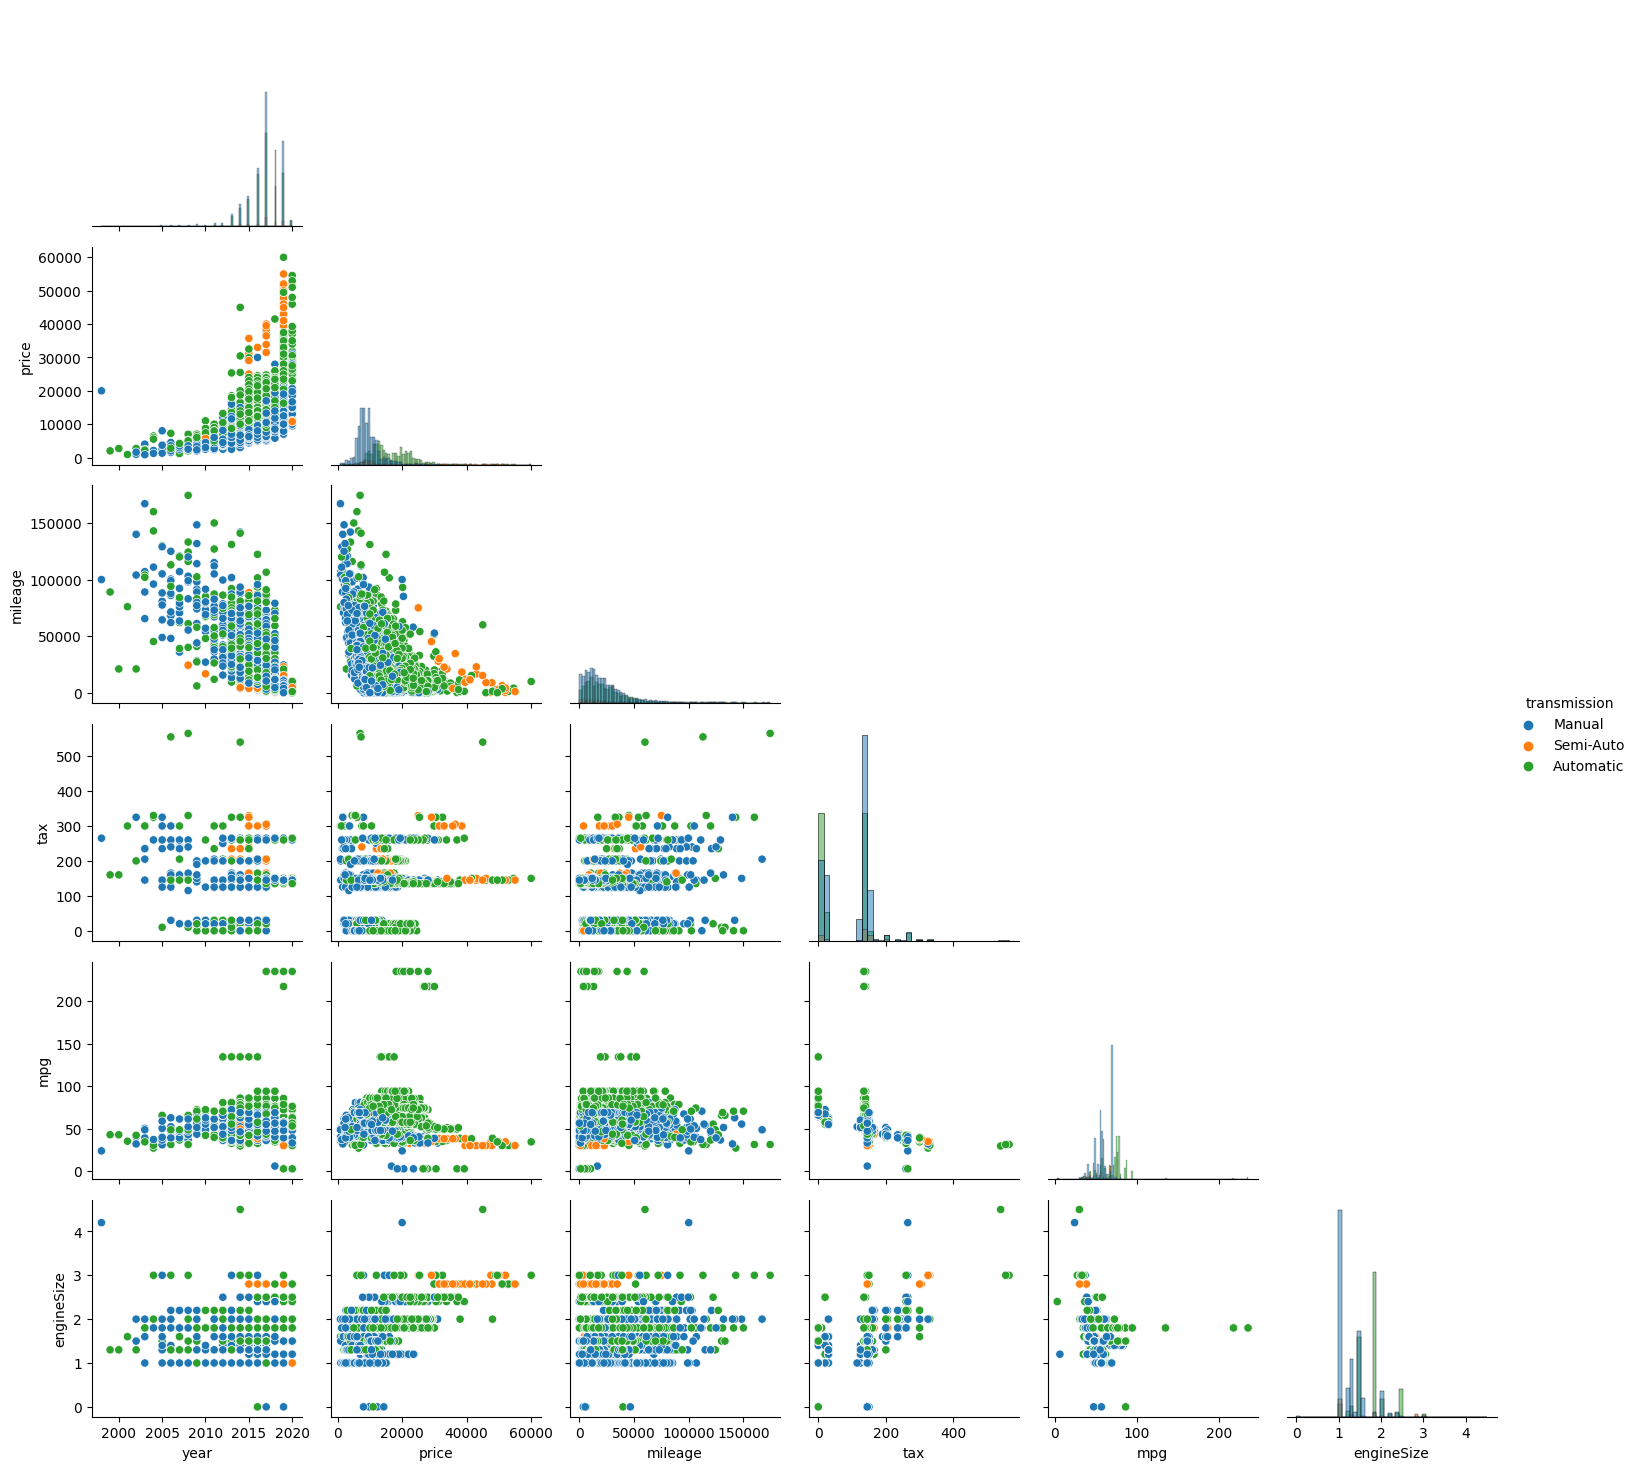

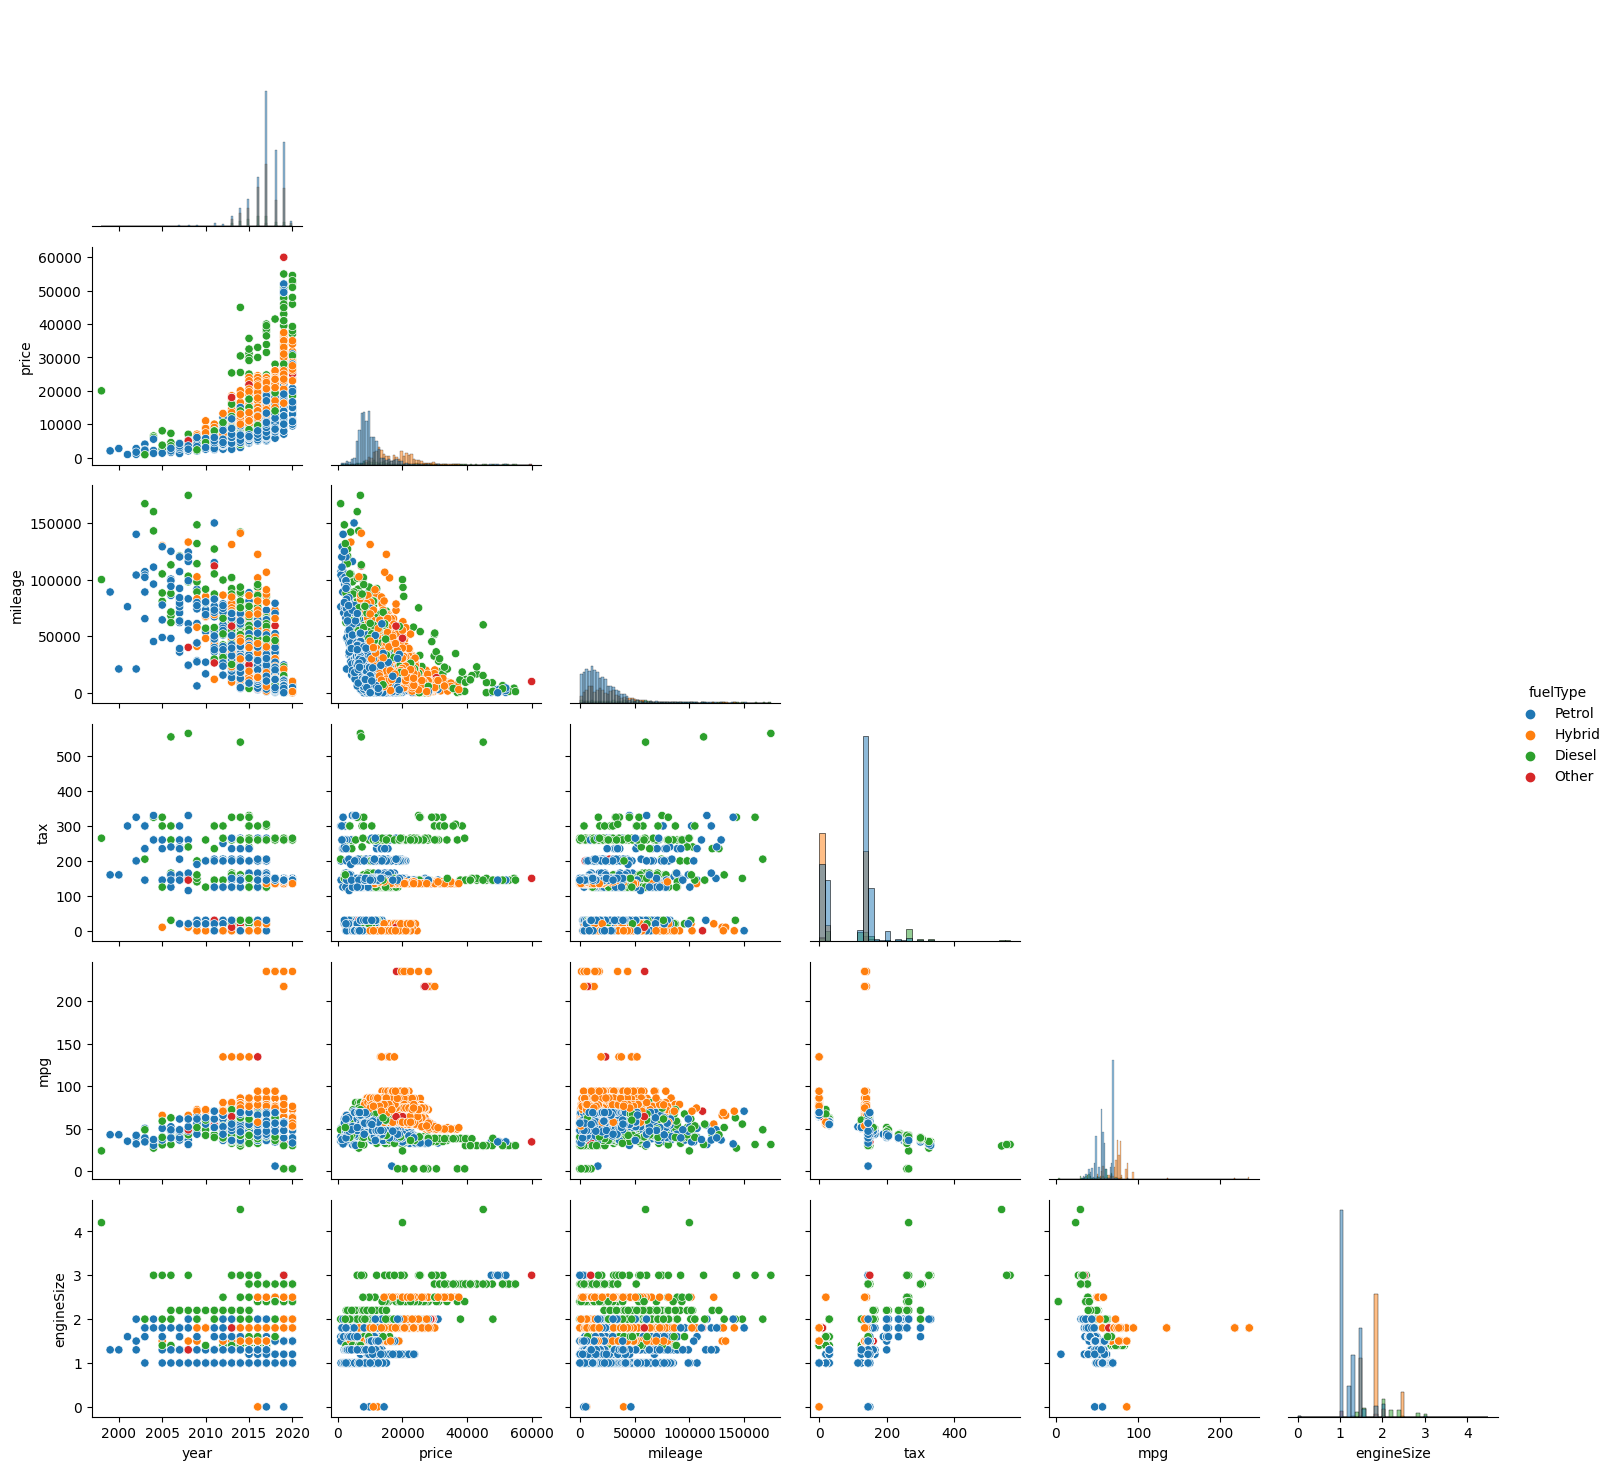

In [96]:
# Multiple Variables

# Relational

# No hue
g = sns.PairGrid(train_data, corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

# With hue for each categorical variable
for col_name in train_data.select_dtypes(exclude="number").columns:
    g = sns.PairGrid(train_data, corner=True, hue=col_name)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()
    plt.show()

**{{ make_observations_here }}**

**Notable relationships to target, correlated predictors, predictor interactions relationships to target, etc.**

* Do any of variables have a noticable relationship to the target (Linear or Non-Linear) ?
  * What does impact does this have on type of models you will test ?
* Are any of the predictors highly correlated (linear correlation) with each other ?
  * [Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) may need to be addressed for Linear Models for interpretability, but does not impact predictive accuracy.
* Do you notice any interesting interactions (X-axis + color) on the target ?
  * If yes, then consider adding interaction terms during feature engineering.

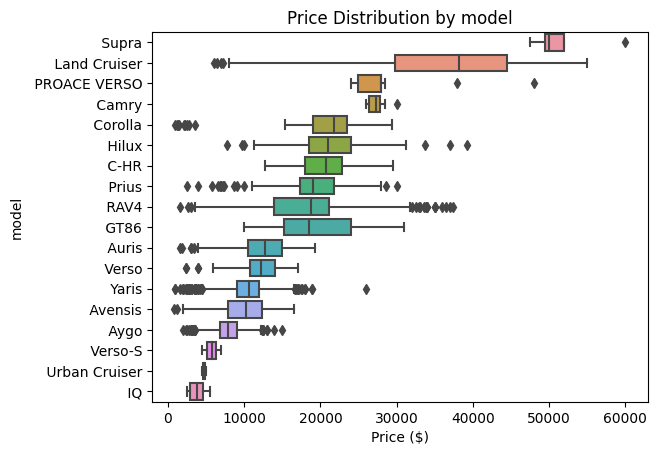

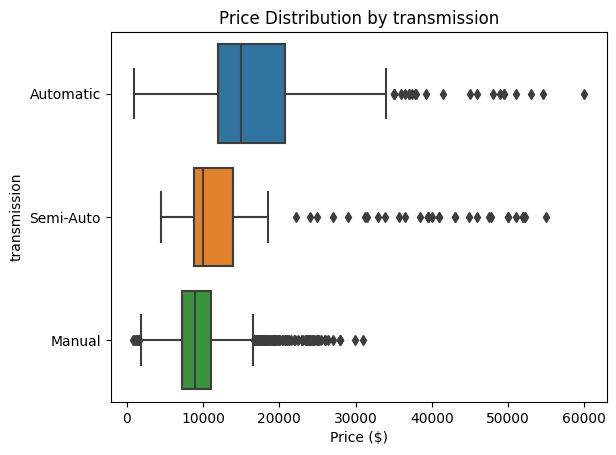

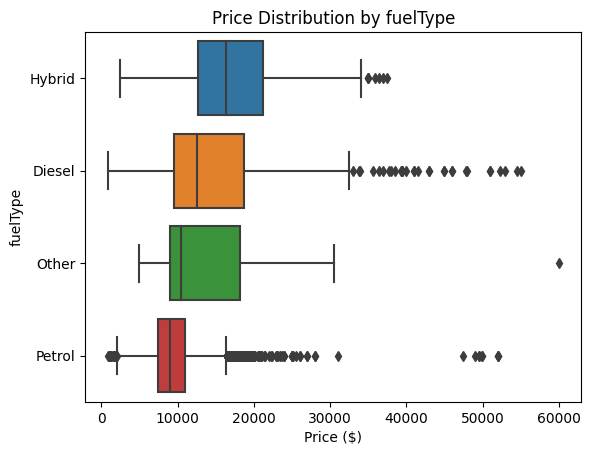

In [97]:
# Multiple Variables

for col_name in train_data.select_dtypes(exclude="number").columns:
    # Medians in descending order
    desc_order = train_data.groupby(by=[col_name])[target].median().sort_values(ascending=False).index
    g = sns.boxplot(data=train_data, y=col_name, x=target, order=desc_order)
    g.set(xlabel="Price ($)", ylabel=col_name)
    g.set_title(f"Price Distribution by {col_name}")
    plt.show()

# Target vs Category for each Category
# g = sns.boxplot(train_data=train_data, y="fuelType", x=target)
# g.set(xlabel="Price ($)", ylabel="Fuel Type")
# g.set_title("Price Distribution by Fuel Type")
# plt.show()

**{{ make_observations_here }}**

**Interesting Interactions**

* Can you identify any relationships between categorical predictor classes and the target ?
  * If, so then try to dig deeper on this relationship when doing *3 variable interaction*
* Explore whether the relationships seen here are independent of other predictors or not
  * Create some hypothesis and test them with more plots

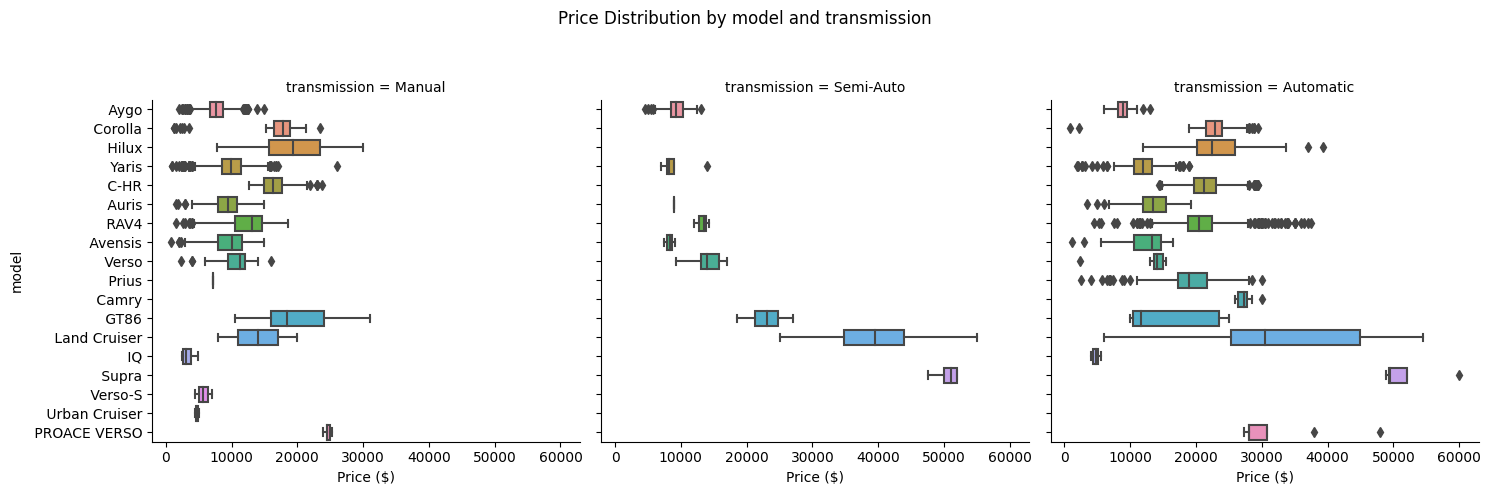

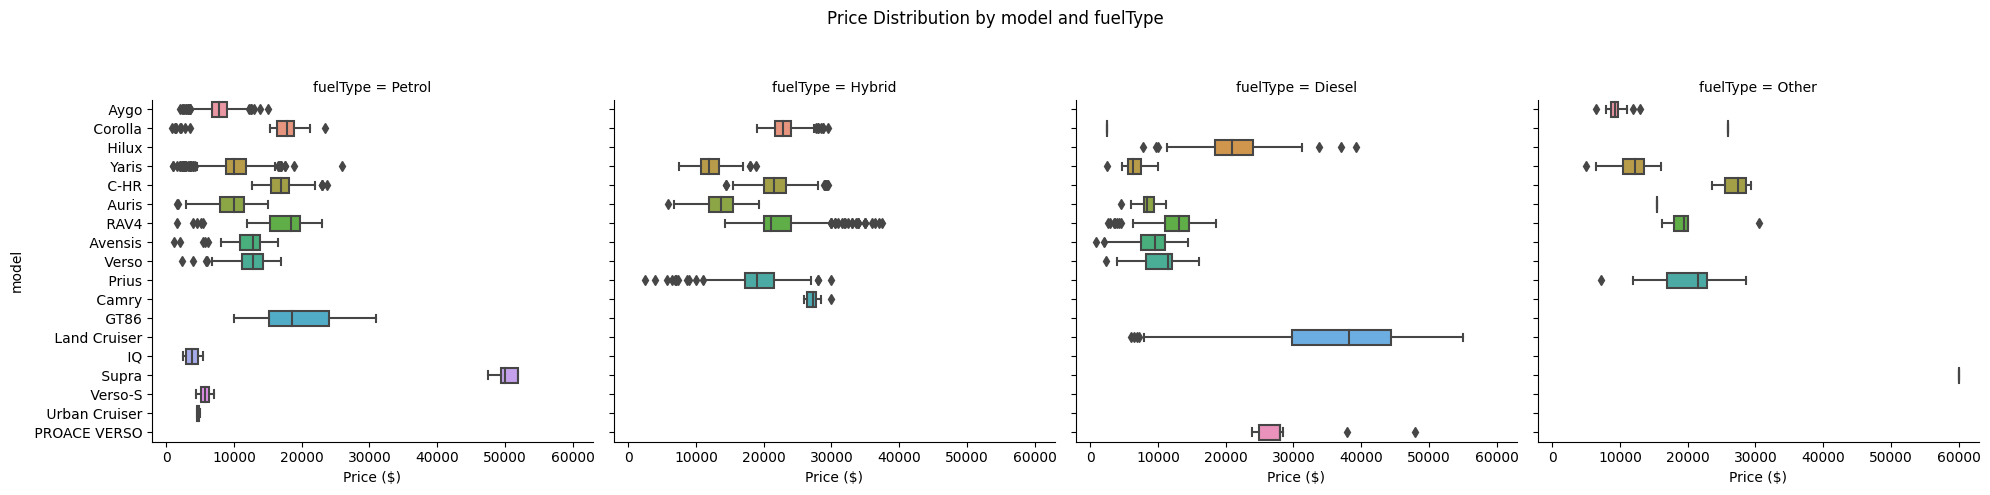

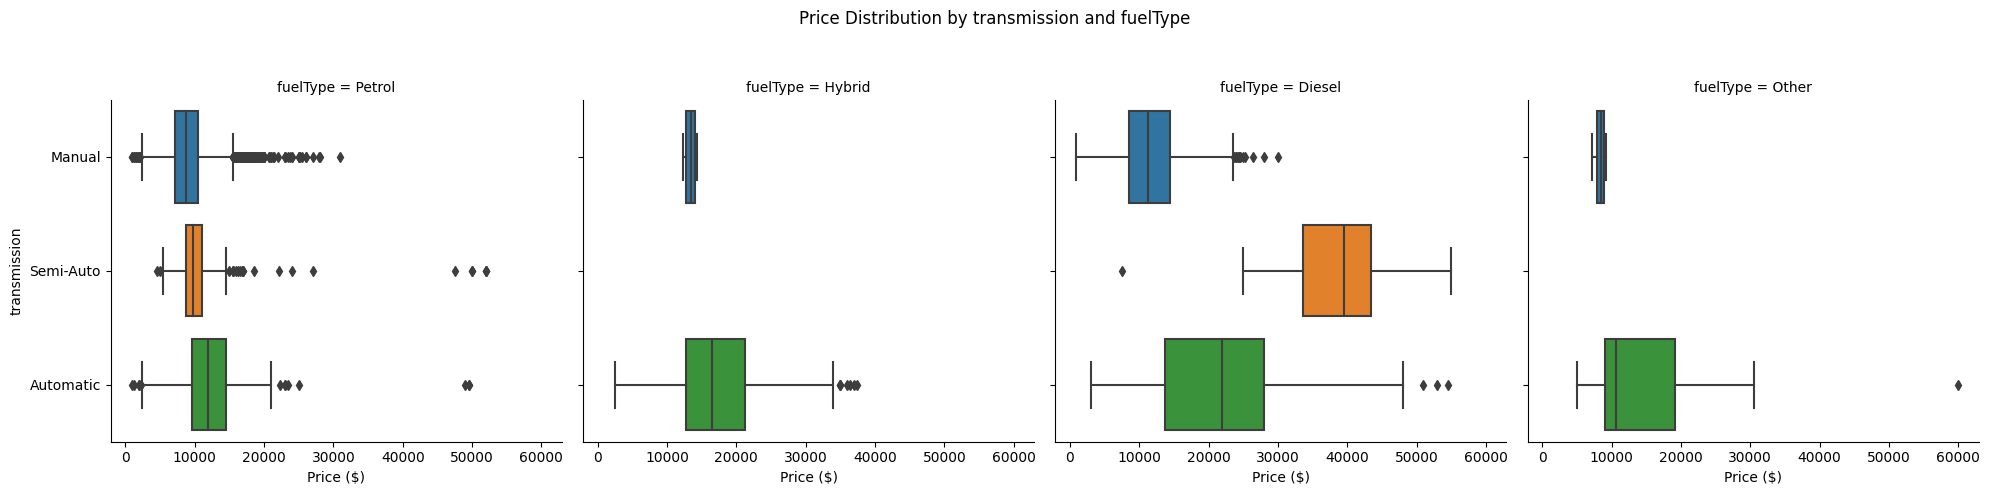

In [98]:
L = train_data.select_dtypes(exclude="number").columns
# All unqiue 2 way combinations
unique_2_way_combos = [comb for comb in combinations(L, 2)]
for i, j in unique_2_way_combos:
    g = sns.catplot(data=train_data, y=i, x=target, col=j, kind="box", col_wrap=3)
    g.set_axis_labels(f"{target}", i)
    g.set_titles("{col_var} = {col_name}")
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(f"{target} Distribution by {i} and {j}")
    plt.show()

**{{ make_observations_here }}**

**Interesting Interactions**

* Can you identify any relationships between categorical predictor classes and the target ?
* Did adding a 3rd variable expose a new trend that you didn't see as clearly with 2 variables ?

interval columns not set, guessing: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']


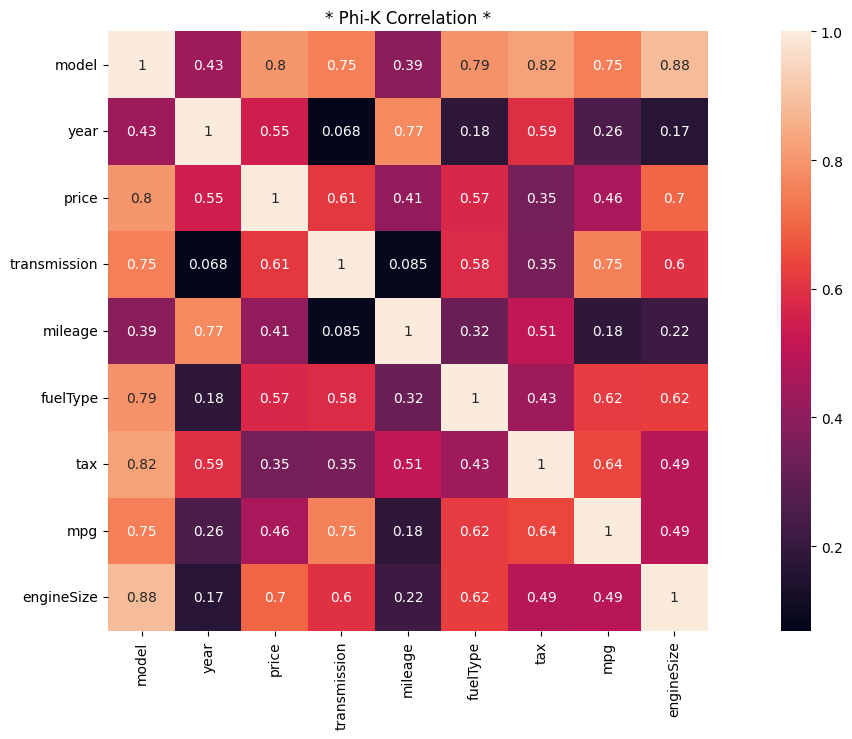

In [99]:
# Phi-k Correlations (Categorical and Numeric combined)
f, ax = plt.subplots(figsize=(15, 7.5))
g = sns.heatmap(data=train_data.phik_matrix(), annot=True, square=True)
g.set(title="* Phi-K Correlation *")
f.set_tight_layout(True)

### Feature Engineering

---

In [100]:
# Create new features based on hypothesis you want to test after EDA
# interaction terms, n-grams and tokenization, 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer

You should make your feature engineering functions and then apply them to the data as a step inside of your `sklearn.Pipeline`.

### Data Preprocessing

---

In [101]:
X_train = train_data.drop(columns=[target])
y_train = train_data[target].copy()

### Baseline Model

---

In [102]:
# Either use a simple model like Linear Regression / KNN or just the average value. You should be able to do better than this
from sklearn.metrics import mean_squared_error

avg_y = y_train.mean()
print(f"Average value of the target = {avg_y:,.2f}")
y_pred = [avg_y] * len(y_train)
baseline_rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"Baseline Model Test RMSE (using mean as the predicted value) = {baseline_rmse:,.2f}")

Average value of the target = 12,504.02
Baseline Model Test RMSE (using mean as the predicted value) = 6,338.66


The baseline model simply used the average value as its prediction for each time. We need our model to be at least better than this simple baseline model's RMSE.

**Add another baseline RMSE here with a simple model**

### Model Building, Selection, and Evaluation

---

In [103]:
# import modules
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [104]:
# Define different Pipelines for Numeric vs. Categorical
# Categorical preprocessing
categorical_pipeline = Pipeline(steps=[
    ('categorical_imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"))
])

# Numeric preprocessing
numeric_pipeline = Pipeline(steps=[
    ('numeric_imputer', SimpleImputer(strategy="median")),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical preprocessing into single preprocessor
numeric_features = X_train.select_dtypes(include="number").columns
categorical_features = X_train.select_dtypes(exclude="number").columns
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical_preprocessor", categorical_pipeline, categorical_features),
        ("numeric_preprocessor", numeric_pipeline, numeric_features),
    ]
)


# Define a single Pipeline with all of the steps
models = [LinearRegression(), KNeighborsRegressor(), RandomForestRegressor(), XGBRegressor()]
cv_rmses = []
for model in models:
    steps = [
        ('preprocessor', preprocessor),
        # Try different models and select the one with the best cross_val_score
        ('regressor', model)
    ]
    pipeline = Pipeline(steps)
    cv_rmse = -cross_val_score(pipeline, X_train, y_train, cv=4, scoring="neg_root_mean_squared_error")
    cv_rmse = pd.Series(cv_rmse)
    print(f"{model} Cross Validation Test RMSE Distribution\n")
    display(cv_rmse.describe())
    # Get the mean_test_score from the cross_val_score
    cv_rmses.append(cv_rmse.mean())


LinearRegression() Cross Validation Test RMSE Distribution



count       4.000000
mean     1756.051444
std        45.946639
min      1703.758825
25%      1728.743660
50%      1755.034381
75%      1782.342166
max      1810.378189
dtype: float64

KNeighborsRegressor() Cross Validation Test RMSE Distribution



count       4.000000
mean     1593.730560
std        65.286101
min      1519.713777
25%      1551.875544
50%      1594.385117
75%      1636.240132
max      1666.438228
dtype: float64

RandomForestRegressor() Cross Validation Test RMSE Distribution



count       4.000000
mean     1321.504157
std        40.949134
min      1283.054578
25%      1295.536519
50%      1313.109165
75%      1339.076803
max      1376.743721
dtype: float64

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) Cross Validation Test RMSE Distribution



count       4.000000
mean     1290.417239
std        99.342318
min      1217.864282
25%      1221.592256
50%      1256.381651
75%      1325.206634
max      1431.041373
dtype: float64

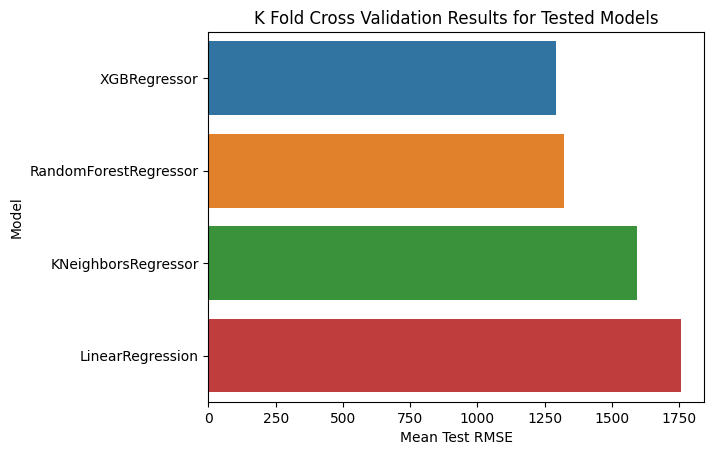

model  cross_validation_rmse
3           XGBRegressor            1290.417239
2  RandomForestRegressor            1321.504157
1    KNeighborsRegressor            1593.730560
0       LinearRegression            1756.051444

Minimum cross validation RMSE (1,290.42) acheived with XGBRegressor model


In [105]:
cv_results = pd.DataFrame({
    "model": [str(model).split("(")[0] for model in models],
    "cross_validation_rmse": cv_rmses
}).sort_values(by="cross_validation_rmse")
sns.barplot(data=cv_results, y="model", x="cross_validation_rmse")
plt.title("K Fold Cross Validation Results for Tested Models")
plt.xlabel("Mean Test RMSE")
plt.ylabel("Model")
plt.show()
display(cv_results)
best_model = cv_results.loc[cv_results['cross_validation_rmse'].idxmin()]['model']
print(f"Minimum cross validation RMSE ({min(cv_results['cross_validation_rmse']):,.2f}) acheived with {best_model} model")

**Explicitly say which model you expect to perform the best and why.**

Cross validation lets us estimate how well our models will perform on the future data (like our Test set), thus we will proceed with the model that yields the lowest cross validation MSE.

The `model` yielded the lowest cross validation MSE, so will use it as our final model and proceed to tuning.

In [106]:
# Inspect parameters that we can tune with `model`.get_params().keys()

In [107]:
# Reset Pipeline with best model
steps = [
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor())
    ]
pipeline = Pipeline(steps)

# Set up the parameter distributions to search over
param_distributions = {}

# Tune the hyperparameters for the best model
cv = RandomizedSearchCV(pipeline
                  , cv = 4
                  , scoring="neg_root_mean_squared_error"
                  , param_distributions=param_distributions
                  , random_state=42)

cv.fit(X_train, y_train)

cv_results = pd.DataFrame(cv.cv_results_)

#### Change from negative to positive RMSE
score_columns = [x for x in cv_results.columns if ("test_score" in x or "train_score" in x)]
score_columns = [x for x in score_columns if "rank" not in x]
score_columns = [x for x in score_columns if "std" not in x]
cv_results[score_columns] = cv_results[score_columns] * -1
print(f"CV Results")
display(cv_results.sort_values(by="mean_test_score").head(5))
print(f"Best Hyperparameters\n{cv.best_params_}")

/Users/nathanjones/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CV Results


mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.424854      0.026535         0.006282        0.000819     {}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0        1222.834914        1431.041373        1217.864282        1289.928387   

   mean_test_score  std_test_score  rank_test_score  
0      1290.417239       86.032971                1

Best Hyperparameters
{}


After experimenting with feature extraction, feature selection, and other processing techniques, you should choose the model that yielded the lowest CV RMSE on the training data.

If the tuned model had the lowest CV RMSE, then make sure you use the hyperparameters you found when you do your final validation on the test set.

This will be the final model that you deploy for future predictions.

### Baseline Model Comparison

In [113]:
# Compare the best model with the baseline model
print(f"Best Model CV Average RMSE Score = {-cv.best_score_:,.2f}")
print(f"Baseline Model Test RMSE (using mean as the predicted value) = {baseline_rmse:,.2f}")
if baseline_rmse < -cv.best_score_:
    print(f"Improvement over the baseline = {baseline_rmse - -cv.best_score_:,.2f}, or {-100 * (-cv.best_score_ - baseline_rmse) / baseline_rmse:,.2f}% Decrease in RMSE")

Best Model CV Average RMSE Score = 1,290.42
Baseline Model Test RMSE (using mean as the predicted value) = 6,338.66
Improvement over the baseline = 5,048.25, or 79.64%


### Final Model Evaluation

In [109]:
# Final evaluation of the model on the test set
X_test = test_data.drop(columns=[target])
y_test = test_data[target].copy()
y_pred = cv.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE = {test_rmse:,.2f}")

Test RMSE = 1,088.29


### Conclusion


---

Comment on your findings here and provide a summary. 

Include: 
1. The model you would choose to deploy (if any) 
2. A table of results of the different models you tested
3. Model performance across different subsets (ie, geographies, customer offering, etc.)
  * Should we not deploy for certain subsets/groups?
4. Steps on how to maintain and update the model in production in a way stakeholders can understand

### Appendix


---

Add any exploratory or supporting work that doesn't fit into the story of your report. Add any citations you used here as well.

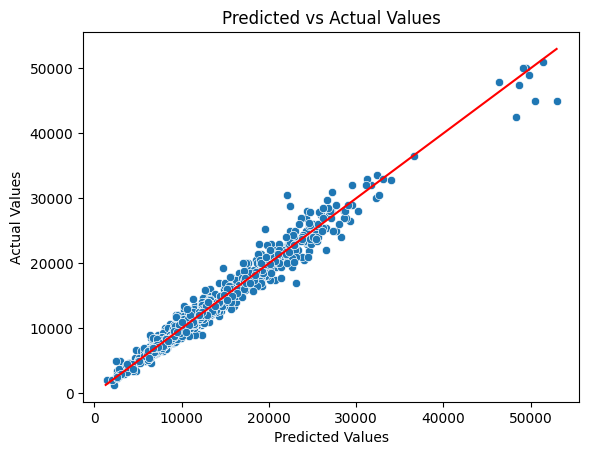

In [110]:
# Add y = x plot as reference for perfect predictions
sns.scatterplot(x=y_pred, y=y_test)
plt.title(f"Predicted vs Actual Values")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
x = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()))
plt.plot(x, x, c="red")
plt.show()

In [111]:
from sklearn.feature_selection import SelectKBest, f_regression

# Checkout how to integrate feature selection methods inside of your Pipeline here: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html

# Get the max number of features that model can use
processing_and_fe_steps = [
    ('preprocessor', preprocessor),
    ('interactions', PolynomialFeatures())
]
processing_and_fe_pipeline = Pipeline(processing_and_fe_steps)
n_features = processing_and_fe_pipeline.fit_transform(X_train).shape[1]

k_list = np.linspace(10, n_features, dtype="int")
test_rmses = []
train_rmses = []
for k in k_list:
    steps = [
        ('preprocessor', preprocessor),
        ('interactions', PolynomialFeatures()),
        ('dim_red', SelectKBest(score_func=f_regression, k=k)),
        # Fill in hyperparameters from CV for best model here
        ('regressor', LinearRegression())
    ]
    pipeline = Pipeline(steps)

    # Fit the model and score it
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred, squared=False)
    train_y_pred = pipeline.predict(X_train)
    train_rmse = mean_squared_error(y_train, train_y_pred, squared=False)
    test_rmses.append(test_rmse)
    train_rmses.append(train_rmse)

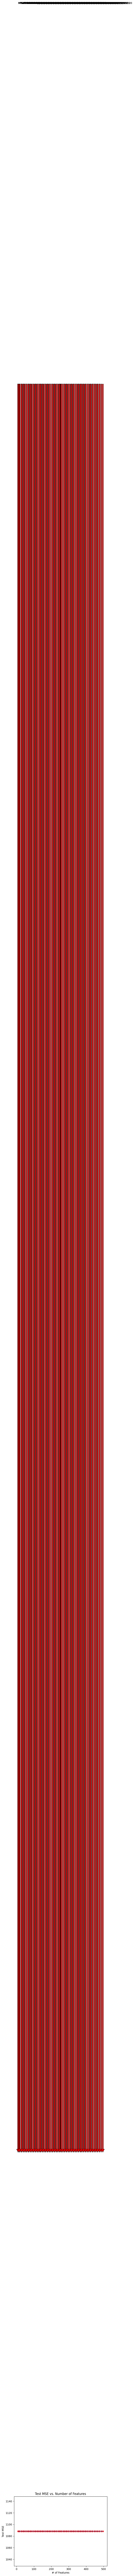

Min Test MSE of 1,088.29 acheived with 10 features
Min Test MSE of 1,088.29 acheived with 19 features
Min Test MSE of 1,088.29 acheived with 29 features
Min Test MSE of 1,088.29 acheived with 39 features
Min Test MSE of 1,088.29 acheived with 49 features
Min Test MSE of 1,088.29 acheived with 59 features
Min Test MSE of 1,088.29 acheived with 69 features
Min Test MSE of 1,088.29 acheived with 79 features
Min Test MSE of 1,088.29 acheived with 89 features
Min Test MSE of 1,088.29 acheived with 99 features
Min Test MSE of 1,088.29 acheived with 109 features
Min Test MSE of 1,088.29 acheived with 119 features
Min Test MSE of 1,088.29 acheived with 129 features
Min Test MSE of 1,088.29 acheived with 138 features
Min Test MSE of 1,088.29 acheived with 148 features
Min Test MSE of 1,088.29 acheived with 158 features
Min Test MSE of 1,088.29 acheived with 168 features
Min Test MSE of 1,088.29 acheived with 178 features
Min Test MSE of 1,088.29 acheived with 188 features
Min Test MSE of 1,088.

In [112]:
# Plot MSE for various # of features
sns.lineplot(x=k_list, y=test_rmses)
minima = []
for i in list(zip(k_list, test_rmses)):
    if i[1] == min(test_rmses):
        minima.append(i)
        for annotation_pt in minima:
            plt.scatter(annotation_pt[0], annotation_pt[1], marker='o', c="red", s=25)
            annotation_text_position = [annotation_pt[0], annotation_pt[1] * 5]
            plt.annotate(f"Min Test MSE {annotation_pt[1]:,.2f}", annotation_pt, xytext=annotation_text_position, arrowprops={'facecolor':'red', "shrink":0.15})
plt.title(f"Test MSE vs. Number of Features")
plt.xlabel("# of Features")
plt.ylabel("Test MSE")
plt.show()
for annotation_pt in minima:
    print(f"Min Test MSE of {annotation_pt[1]:,.2f} acheived with {annotation_pt[0]} features")